# Purpose:
- Develop Lasso regression for neuronal activities
- Using the same design matrix and splits as from the ridge.
- pyglmnet or sklearn?

In [2]:
# from pyglmnet import GLM
import numpy as np
import pandas as pd
from importlib import reload
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('default')
import xarray as xr
from utils import lda_angle_discrim as lad
from sklearn.linear_model import ElasticNet
import socket
hostname = socket.gethostname()

if hostname == 'HNB228-LABPC6':
    base_dir = Path(r'D:\JK\h5')
    b_dir = Path(r'D:\JK\SoloData')
else:
    base_dir = Path(r'E:\TPM\JK\h5')
    b_dir = Path(r'E:\TPM\JK\SoloData')
results_dir = base_dir / 'results'
wf_dir = results_dir / 'touch_whisker_features'

expert_mice_df = pd.read_csv(base_dir / 'expert_mice.csv', index_col=0)
use_mice_df = expert_mice_df.loc[expert_mice_df['depth_matched'].astype(bool) & 
                                 ~expert_mice_df['processing_error'].astype(bool) &
                                 ((expert_mice_df.session_type == 'training') |
                                  (expert_mice_df.session_type.str.contains('test')))]
use_volume_df = use_mice_df.query('plane in [1, 5]')
use_volume_df.loc[:, 'volume'] = use_volume_df['plane'].apply(lambda x: 1 if x==1 else 2)
training_volume_df = use_volume_df.query('session_type == "training"')
remove_ind = training_volume_df.query('mouse==27 and session=="15"')
training_volume_df = training_volume_df.drop(remove_ind.index)
remove_ind = training_volume_df.query('mouse==36 and session=="9"')
training_volume_df = training_volume_df.drop(remove_ind.index)

mice = [25,27,30,36,39,52]
test_sessions = [[4,19], [3,8], [3,21], [1,17], [1,23], [3,21]]
naive_sessions = [10, 4, 11, 6, 6, 11]

c:\Users\shires\.conda\envs\suite2p\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [5]:
ridge_dir = results_dir / 'neuron_glm/ridge/whisker_combined'
lasso_dir = results_dir / 'neuron_glm/lasso/whisker_combined'


In [8]:
mouse = 25
plane = 1
session = 1
design_pkl = ridge_dir / f'JK{mouse:03}S{session:02}_plane{plane}_design_whisker_combined.pkl'
design = pd.read_pickle(design_pkl)
split_fn = ridge_dir / f'JK{mouse:03}S{session:02}_plane{plane}_glm_split.npy'
split = np.load(split_fn, allow_pickle=True).item()
rigde_result_fn = ridge_dir / f'JK{mouse:03}S{session:02}_plane{plane}_glm_result.nc'
with xr.open_dataset(rigde_result_fn) as ds:
    ridge_result = ds.load()


In [12]:
traces = ridge_result['traces']
X = ridge_result['X']

In [6]:
split.keys()

dict_keys(['lambda_groups', 'fit_groups'])

In [43]:
lam_grid = np.logspace(-4, 0, 20)
lam_grid

array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00])

In [85]:
lambda_groups = split['lambda_groups']
num_lam_splits = len(lambda_groups)
n_cells = traces.shape[1]
n_lams = len(lam_grid)
varexps = np.zeros((n_cells, n_lams, num_lam_splits))
for lam_i, lam in enumerate(lam_grid):
    for spi in range(num_lam_splits):
        train_inds = np.concatenate([lambda_groups[i] for i in range(num_lam_splits) if i != spi])
        test_inds = lambda_groups[spi]
        X_train = X.isel(index=train_inds)
        X_test = X.isel(index=test_inds)
        y_train = traces.isel(index=train_inds)
        y_test = traces.isel(index=test_inds)
        glm = ElasticNet(alpha=lam, l1_ratio=0.95, fit_intercept=False)
        glm.fit(X_train, y_train)
        y_pred = glm.predict(X_test)
        varexps[:, lam_i, spi] = 1 - np.var(y_test - y_pred, axis=0) / np.var(y_test, axis=0)
varexps[np.isinf(varexps)] = np.nan
mean_varexps = np.nanmean(varexps, axis=2)

In [42]:
lam_grid

array([1.00000000e-08, 2.63665090e-08, 6.95192796e-08, 1.83298071e-07,
       4.83293024e-07, 1.27427499e-06, 3.35981829e-06, 8.85866790e-06,
       2.33572147e-05, 6.15848211e-05, 1.62377674e-04, 4.28133240e-04,
       1.12883789e-03, 2.97635144e-03, 7.84759970e-03, 2.06913808e-02,
       5.45559478e-02, 1.43844989e-01, 3.79269019e-01, 1.00000000e+00])

In [46]:
np.argmax(mean_varexps, axis=1)

array([12,  4,  5, 14, 14, 10, 14,  9,  6, 11, 10,  9,  9, 12, 10, 10, 11,
        9,  9, 11, 11, 12, 13, 12,  9, 13,  8, 12, 10,  9, 10,  9, 14,  8,
       11, 11,  8,  9, 13, 11, 10,  9, 10, 10, 10,  9,  9, 10, 12,  7, 11,
       10, 14, 10, 11, 14, 13, 11, 11, 11,  9, 10,  9, 10,  9, 10,  9, 10,
       11,  9, 12, 10, 10,  9, 11,  9,  9,  6, 12,  9, 11, 10,  8,  9,  8,
       15,  9,  8,  9,  9,  8, 11, 12, 10, 10, 10,  9, 10, 10, 13, 11,  8,
        9, 13,  8, 10, 10, 13, 11,  9,  5,  9,  8, 12, 14,  9, 10, 11,  9,
       11], dtype=int64)

In [45]:
lam_grid[np.argmax(mean_varexps, axis=1)]

array([0.03359818, 0.00069519, 0.00112884, 0.08858668, 0.08858668,
       0.01274275, 0.08858668, 0.0078476 , 0.00183298, 0.02069138,
       0.01274275, 0.0078476 , 0.0078476 , 0.03359818, 0.01274275,
       0.01274275, 0.02069138, 0.0078476 , 0.0078476 , 0.02069138,
       0.02069138, 0.03359818, 0.05455595, 0.03359818, 0.0078476 ,
       0.05455595, 0.00483293, 0.03359818, 0.01274275, 0.0078476 ,
       0.01274275, 0.0078476 , 0.08858668, 0.00483293, 0.02069138,
       0.02069138, 0.00483293, 0.0078476 , 0.05455595, 0.02069138,
       0.01274275, 0.0078476 , 0.01274275, 0.01274275, 0.01274275,
       0.0078476 , 0.0078476 , 0.01274275, 0.03359818, 0.00297635,
       0.02069138, 0.01274275, 0.08858668, 0.01274275, 0.02069138,
       0.08858668, 0.05455595, 0.02069138, 0.02069138, 0.02069138,
       0.0078476 , 0.01274275, 0.0078476 , 0.01274275, 0.0078476 ,
       0.01274275, 0.0078476 , 0.01274275, 0.02069138, 0.0078476 ,
       0.03359818, 0.01274275, 0.01274275, 0.0078476 , 0.02069

(array([72., 16.,  7.,  5.,  4.,  5.,  4.,  2.,  3.,  2.]),
 array([-2.96020282e-06,  3.34829660e-02,  6.69688922e-02,  1.00454818e-01,
         1.33940745e-01,  1.67426671e-01,  2.00912597e-01,  2.34398523e-01,
         2.67884449e-01,  3.01370376e-01,  3.34856302e-01]),
 <BarContainer object of 10 artists>)

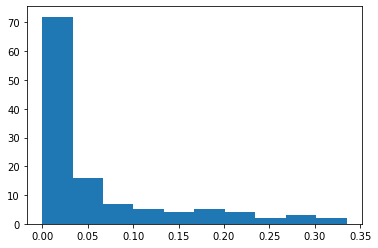

In [88]:
plt.hist(np.amax(mean_varexps, axis=1))

In [86]:
def fit_glm_lasso(trace, X, lam, fit_intercept=False):
    if fit_intercept == False:
        assert 'intercept' in X.feature.values
    glm = ElasticNet(alpha=lam, l1_ratio=0.95, fit_intercept=fit_intercept)
    glm.fit(X, trace)
    return glm

In [98]:
def glm_variance_ratio(glm, trace, X):
    pred = glm.predict(X)
    ve = 1 - np.var(trace - pred, axis=0) / np.var(trace, axis=0)
    return pred, ve

In [52]:
def variance_ratio(traces, W, X): 
    '''
    Computes the fraction of variance in traces explained by the linear model Y = X*W
    
    traces: xarray (n_frames, n_cells)
    W: xarray (n_features, n_cells)
    X: xarray (n_frames, n_features)
    '''
    if len(traces.shape) == 1:
        assert len(traces) == X.shape[0]
        trace = traces.values[:,np.newaxis]
    elif len(traces.shape) == 2:
        trace = traces.values
    pred = X.values @ W.values
    ve = 1 - (np.var(trace - pred, axis=0) / np.var(trace, axis=0))
    return pred, ve

In [99]:
fit_groups = split['fit_groups']
lambdas = lam_grid[np.argmax(mean_varexps, axis=1)]

predicted_fold = np.zeros(traces.shape)
varexp_fold = np.zeros((traces.shape[1], len(fit_groups)))
W_all = xr.DataArray(np.zeros((X.shape[-1], traces.shape[1], len(fit_groups))),
                    dims=('feature', 'cell_id', 'fold'),
                    coords={'feature': X.feature.values,
                            'cell_id': traces.cell_id.values,
                            'fold': [f'fold_{i}' for i in np.arange(len(fit_groups))]})

for fi in range(len(fit_groups)):
    train_inds = np.concatenate([fit_groups[k] for k in np.setdiff1d(range(len(fit_groups)), fi)])
    test_inds = fit_groups[fi]
    for ci in range(traces.shape[1]):
        lam = lambdas[ci]
        glm = fit_glm_lasso(traces.isel(index=train_inds,cell_id=ci), X.isel(index=train_inds), lam,
                            fit_intercept=False)
        W_all[:,ci,fi] = glm.coef_.squeeze()
        pred, ve = glm_variance_ratio(glm, traces.isel(index=test_inds,cell_id=ci), X.isel(index=test_inds))
        predicted_fold[test_inds,ci] = pred.reshape((len(test_inds),))
        varexp_fold[ci, fi] = ve
varexp_fold = xr.DataArray(varexp_fold,
                            dims=('cell_id', 'fold'),
                            coords={'cell_id':traces.cell_id.values,
                                    'fold': [f'fold_{i}' for i in np.arange(len(fit_groups))]})
predicted_fold = xr.DataArray(predicted_fold, dims=('index', 'cell_id'),
                            coords={'index':traces.index.values,
                                    'cell_id':traces.cell_id.values})

# adding final model of a cell  
W_final = W_all.mean(dim='fold')
pred_final_w, ve_final_w = variance_ratio(traces, W_final, X)
glm = ElasticNet(alpha=1, l1_ratio=0.95, fit_intercept=False)
glm.coef_ = W_final.values.T
glm.intercept_ = 0
pred_final, ve_final = glm_variance_ratio(glm, traces, X)
predicted_final = xr.DataArray(pred_final, dims=('index', 'cell_id'),
                            coords={'index':traces.index.values,
                                    'cell_id':traces.cell_id.values})
ve_final = xr.DataArray(ve_final, dims=('cell_id'),
                            coords={'cell_id':traces.cell_id.values})

In [105]:
X.feature.values


array(['intercept', 'theta_onset_0', 'theta_onset_1', 'theta_onset_2',
       'phi_onset_0', 'phi_onset_1', 'phi_onset_2', 'kappaH_onset_0',
       'kappaH_onset_1', 'kappaH_onset_2', 'kappaV_onset_0',
       'kappaV_onset_1', 'kappaV_onset_2', 'arc_length_onset_0',
       'arc_length_onset_1', 'arc_length_onset_2', 'touch_count_0',
       'touch_count_1', 'touch_count_2', 'delta_theta_0', 'delta_theta_1',
       'delta_theta_2', 'delta_phi_0', 'delta_phi_1', 'delta_phi_2',
       'delta_kappaH_0', 'delta_kappaH_1', 'delta_kappaH_2',
       'delta_kappaV_0', 'delta_kappaV_1', 'delta_kappaV_2',
       'touch_duration_0', 'touch_duration_1', 'touch_duration_2',
       'slide_distance_0', 'slide_distance_1', 'slide_distance_2',
       'num_whisks_-2', 'num_whisks_-1', 'num_whisks_0', 'num_whisks_1',
       'num_whisks_2', 'num_whisks_3', 'num_whisks_4', 'midpoint_-2',
       'midpoint_-1', 'midpoint_0', 'midpoint_1', 'midpoint_2',
       'midpoint_3', 'midpoint_4', 'amplitude_-2', 'amplit

In [80]:
glm_variance_ratio(glm, traces.isel(index=test_inds,cell_id=ci), X.isel(index=test_inds))

<xarray.DataArray 'traces' ()>
array(0.02660703)
Coordinates:
    cell_id  int32 0

## For dropping features

In [106]:
whisker_feature_names_base = ['theta_onset', 'phi_onset', 'kappaH_onset', 'kappaV_onset',
        'arc_length_onset', 'touch_count', 'delta_theta', 'delta_phi',
        'delta_kappaH', 'delta_kappaV', 'touch_duration', 'slide_distance']
whisker_feature_names = [key for key in X.feature.values if sum([wfnb in key for wfnb in whisker_feature_names_base])==1]
whisking_names = [key for key in X.feature.values if ('num_whisks' in key) or ('midpoint' in key) or ('amplitude' in key)]
lick_names = [key for key in X.feature.values if 'num_lick' in key]
sound_names = [key for key in X.feature.values if 'pole_in_frame' in key or 'pole_out_frame' in key]
reward_names = [key for key in X.feature.values if 'first_reward_lick' in key]
feature_names = {'whisker_feature': whisker_feature_names,
                'whisking': whisking_names,
                'lick': lick_names,
                'sound': sound_names,
                'reward': reward_names}

In [111]:
n_cells = traces.shape[1]
n_features = len(feature_names)
varexp_drop = xr.DataArray(np.zeros((n_cells, n_features)),
                        dims=('cell_id', 'dropped_feature'),
                        coords={'cell_id':traces.cell_id.values,
                                'dropped_feature': list(feature_names.keys())})
predicted_drop = xr.DataArray(np.zeros((*traces.shape, n_features)),
                                dims=('index', 'cell_id', 'dropped_feature'),
                                coords={'index':traces.index.values,
                                        'cell_id':traces.cell_id.values,
                                        'dropped_feature': list(feature_names.keys())})
W_drop = xr.DataArray(np.zeros((X.shape[-1], n_cells, n_features)),
                        dims=('feature', 'cell_id', 'dropped_feature'),
                        coords={'feature': X.feature.values,
                                'cell_id':traces.cell_id.values,
                                'dropped_feature': list(feature_names.keys())})
lambdas_drop = xr.DataArray(np.zeros((n_cells, n_features)),
                        dims=('cell_id', 'dropped_feature'),
                        coords={'cell_id':traces.cell_id.values,
                                'dropped_feature': list(feature_names.keys())})

In [126]:
from scripts import fit_glm_whisker_combined as fgwc
for fni, key in enumerate(feature_names.keys()):
    X_temp = X.sel(feature=np.setdiff1d(X.feature.values, feature_names[key]))
    lam_d, _ = fgwc.lasso_find_lambda(traces, X_temp, lambda_groups)
    # W_d = fgwc.fit_glm_lasso(traces, X_temp, lam_d)
    # pred_d, ve_d = fgwc.variance_ratio(traces, W_d, X_temp)
    pred_d, ve_d, W_d, _, _, _ = fgwc.fit_model(X_temp, traces, fit_groups, lam_d, model='lasso')
    varexp_drop[:,fni] = ve_d
    predicted_drop[:,:,fni] = pred_d
    matching_indices = {'feature': W_d['feature'], 'cell_id': W_d['cell_id'], 'dropped_feature': key}
    W_drop.loc[matching_indices] = W_d
    lambdas_drop[:,fni] = lam_d

In [128]:
# Compare with another run
lasso_dir = results_dir / 'neuron_glm/lasso/whisker_combined'
lasso_fn = lasso_dir / f'JK{mouse:03}S{session:02}_plane{plane}_glm_result.nc'
with xr.open_dataset(lasso_fn) as ds:
    lasso_result = ds.load()


In [133]:
predicted_drop.shape

(4106, 120, 5)

In [134]:
lasso_result['predicted_drop'].shape

(4106, 120, 5)

In [135]:
varexp_drop.shape

(120, 5)

In [136]:
lasso_result['varexp_drop'].shape

(120, 5)

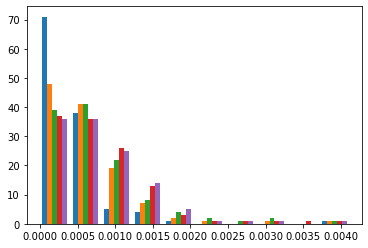

In [138]:
plt.hist(lasso_result['varexp_drop'] - varexp_drop);

# Check parallel results

In [5]:
glm_not_run = []
split_not_run= []
glm_dir = base_dir / 'results/neuron_glm/lasso/whisker_combined'
for i, row in use_mice_df.iterrows():
    mouse = row.mouse
    plane = row.plane
    session = int(row.session)
    glm_save_fn = glm_dir / f'JK{mouse:03}S{session:02}_plane{plane}_glm_result.nc'
    split_save_fn = glm_dir / f'JK{mouse:03}S{session:02}_plane{plane}_glm_split.npy'
    if not glm_save_fn.exists():
        glm_not_run.append((mouse, plane, session))
    if not split_save_fn.exists():
        split_not_run.append((mouse, plane, session))



In [6]:
len(glm_not_run)

192

In [7]:
len(split_not_run)

192

In [8]:
glm_not_run

[(25, 5, 15),
 (27, 3, 6),
 (27, 4, 2),
 (27, 4, 5),
 (27, 5, 10),
 (27, 5, 12),
 (27, 5, 15),
 (27, 5, 16),
 (27, 8, 1),
 (36, 1, 2),
 (36, 1, 8),
 (36, 1, 10),
 (36, 1, 13),
 (36, 2, 2),
 (36, 2, 3),
 (36, 2, 5),
 (36, 2, 6),
 (36, 2, 8),
 (36, 2, 9),
 (36, 2, 13),
 (36, 2, 15),
 (36, 2, 17),
 (36, 3, 1),
 (36, 3, 2),
 (36, 3, 3),
 (36, 3, 4),
 (36, 3, 6),
 (36, 3, 7),
 (36, 3, 8),
 (36, 3, 9),
 (36, 3, 10),
 (36, 3, 16),
 (36, 4, 1),
 (36, 4, 2),
 (36, 4, 3),
 (36, 4, 4),
 (36, 4, 5),
 (36, 4, 6),
 (36, 4, 7),
 (36, 4, 8),
 (36, 4, 9),
 (36, 4, 10),
 (36, 4, 13),
 (36, 4, 17),
 (36, 5, 2),
 (36, 5, 3),
 (36, 5, 4),
 (36, 5, 5),
 (36, 5, 6),
 (36, 5, 7),
 (36, 5, 8),
 (36, 5, 9),
 (36, 6, 2),
 (36, 6, 3),
 (36, 6, 5),
 (36, 6, 6),
 (36, 6, 17),
 (36, 7, 2),
 (36, 7, 3),
 (36, 7, 5),
 (36, 7, 6),
 (36, 7, 13),
 (36, 7, 14),
 (36, 7, 17),
 (36, 8, 2),
 (36, 8, 3),
 (36, 8, 4),
 (36, 8, 5),
 (36, 8, 6),
 (36, 8, 7),
 (36, 8, 8),
 (36, 8, 9),
 (36, 8, 13),
 (36, 8, 14),
 (39, 1, 5),
 (39